# Segmentation Notebook
---
Notebook to experiment / compare various segmentation algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from data.load_data import load_dataset
from segmentation.segmentation import extract_objects
from source.objects import ARC_Object
from image_encoding.embedding import get_embedding
from source.util import plot_tensors_with_colors, plot_image_and_mask

c:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\arc-291c\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\arc-291c\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
train_dataset = load_dataset(mode='training')
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = load_dataset(mode='evaluation')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Problem 22233c11:

Input Image:


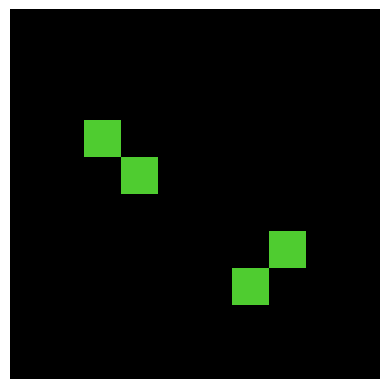


Output Image:


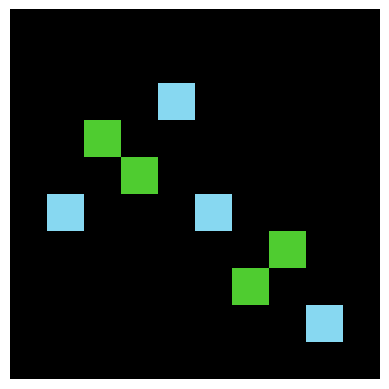

Further segmented inputs by 2 objects and outputs by 3 objects.


In [5]:
my_objs = dict()

# Main loop processing data
for i, data in enumerate(train_dataloader):
    id = data['id'][0]
    train = data['train']
    test = data['test']
    
    for t in train:
        # Will work within numpy for simplicity
        input_image = t['input'].squeeze(0).numpy()
        output_image = t['output'].squeeze(0).numpy()

        # Convert to ARC_Objects and add to our dict
        input_object = ARC_Object(input_image, np.ones_like(input_image))
        output_object = ARC_Object(output_image, np.ones_like(output_image))
        my_objs[id] = {'input': [input_object], 'output': [output_object]}

        # Print out problem (input and output)
        print(f"Problem {id}:\n{'='*100}")
        print("\nInput Image:")
        plot_image_and_mask(input_image)
        print("\nOutput Image:")
        plot_image_and_mask(output_image)
        
        # Extract objects using segmentation
        input_extraction = extract_objects(input_object, method='color')
        output_extraction = extract_objects(output_object, method='color')
        print(f"Further segmented inputs by {len(input_extraction)} objects and outputs by {len(output_extraction)} objects.")
        
        # Add to our dict
        my_objs[id]['input'].extend(input_extraction)
        my_objs[id]['output'].extend(output_extraction)
        break
    break

Source Object:


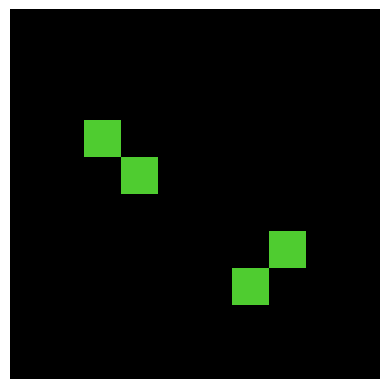

Segmented Objects:


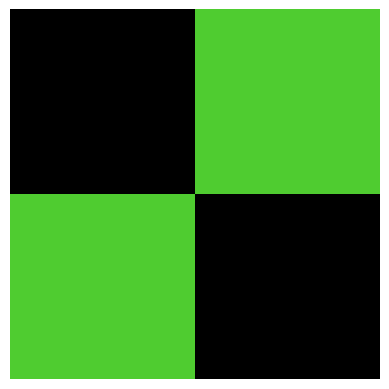

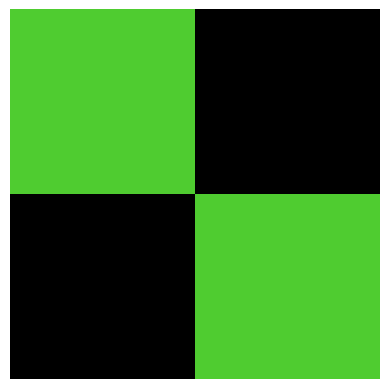

Further segmented into 2 objects


Source Object:


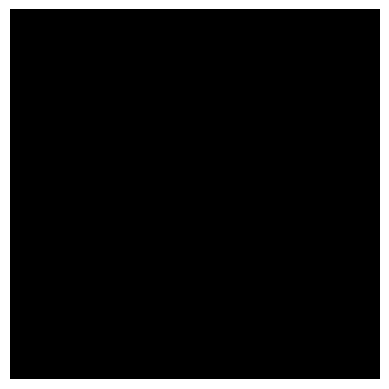

Segmented Objects:
Further segmented into 0 objects


Source Object:


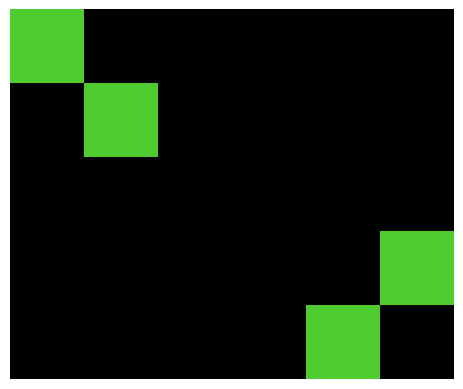

Segmented Objects:


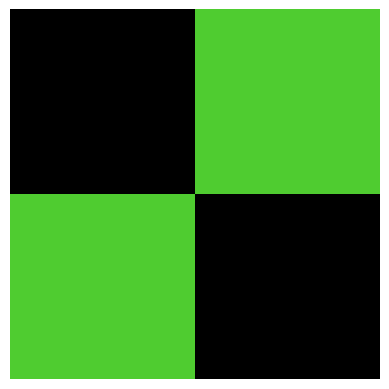

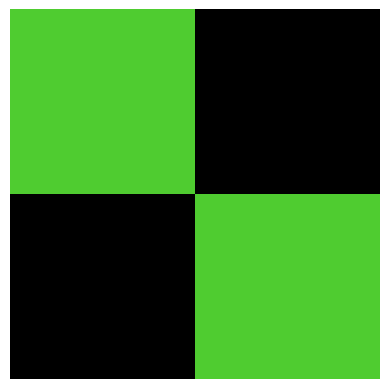

Further segmented into 2 objects


Source Object:


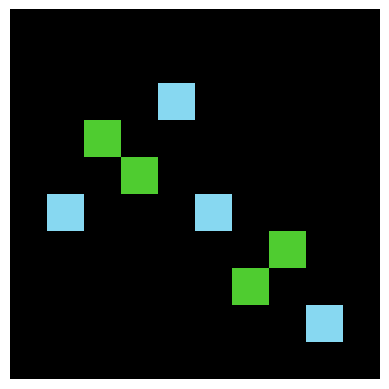

Segmented Objects:


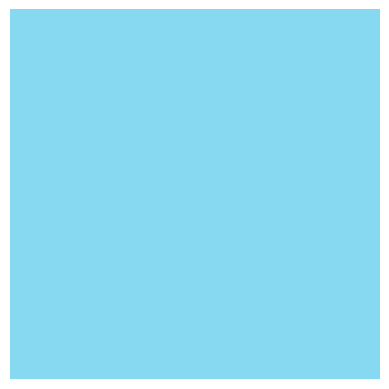

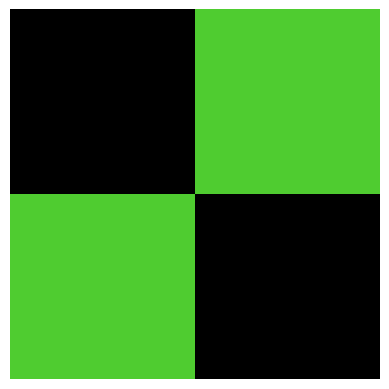

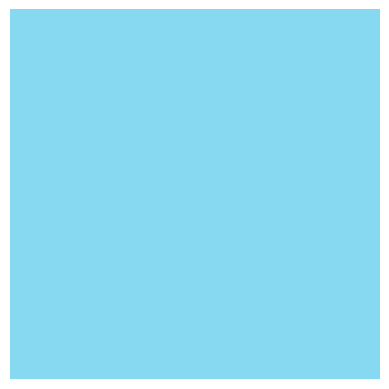

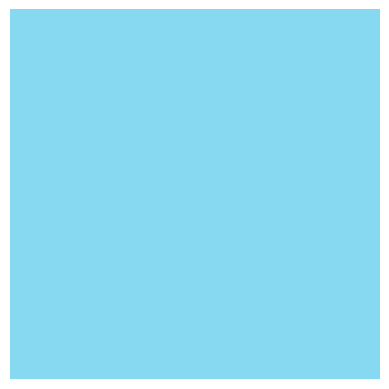

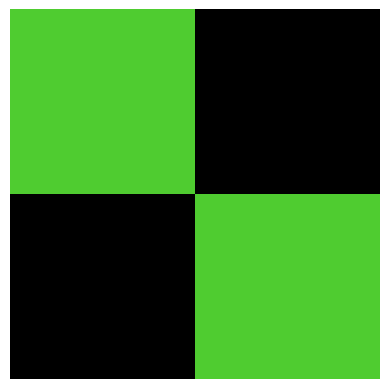

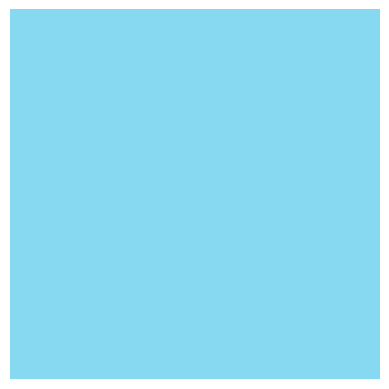

Further segmented into 6 objects


Source Object:


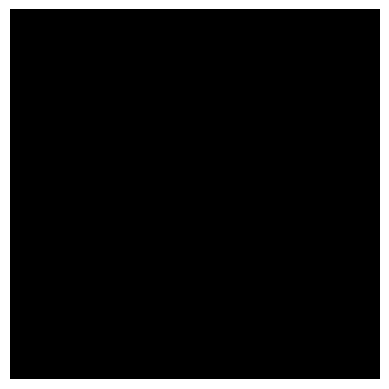

Segmented Objects:
Further segmented into 0 objects


Source Object:


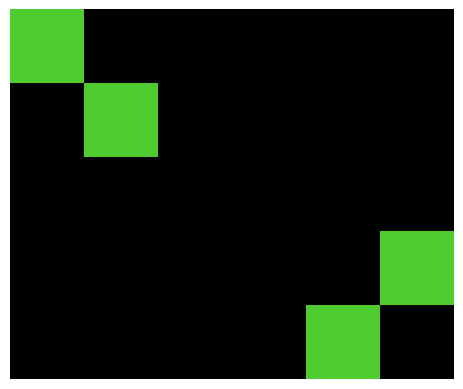

Segmented Objects:


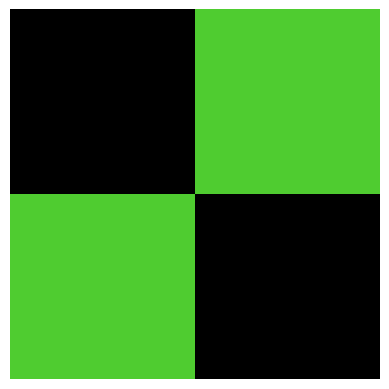

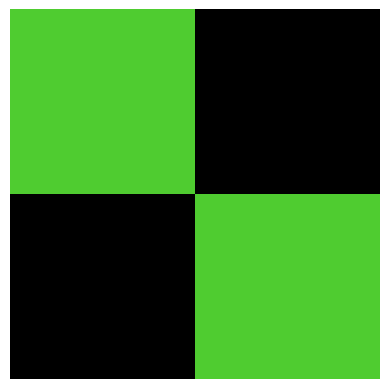

Further segmented into 2 objects


Source Object:


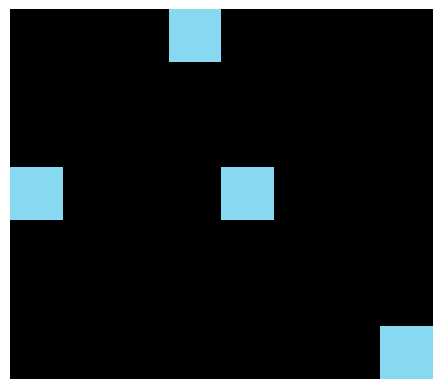

Segmented Objects:


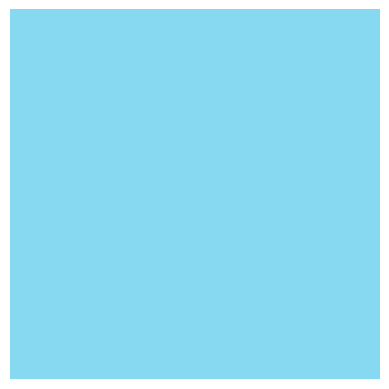

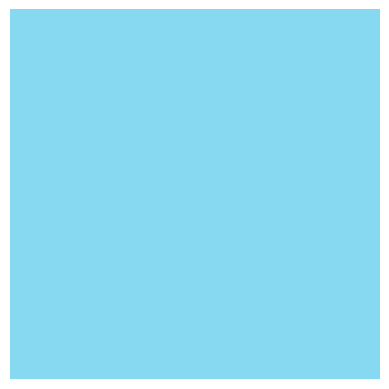

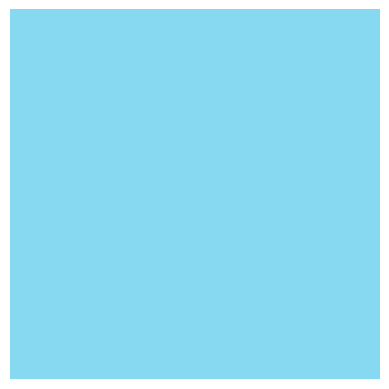

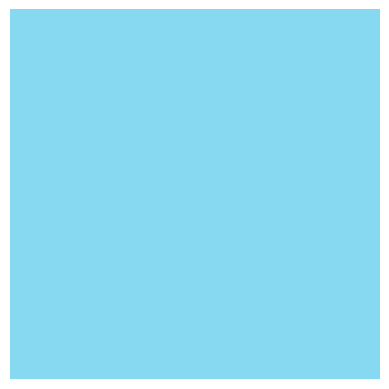

Further segmented into 4 objects




In [7]:
problem_id = "22233c11"

input_objs = my_objs[problem_id]['input']
output_objs = my_objs[problem_id]['output']
print_segmented_objects = True

for obj in input_objs:
    print(f"Source Object:\n{'='*100}")
    obj.plot_grid()
    print(f"Segmented Objects:\n{'='*100}")
    new_objs = extract_objects(obj, method='contour', print_on_init=print_segmented_objects)
    print(f"Further segmented into {len(new_objs)} objects\n\n")

for obj in output_objs:
    print(f"Source Object:\n{'='*100}")
    obj.plot_grid()
    print(f"Segmented Objects:\n{'='*100}")
    new_objs = extract_objects(obj, method='contour', print_on_init=print_segmented_objects)
    print(f"Further segmented into {len(new_objs)} objects\n\n")